## Dependencies

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("dataset_new.csv")
df.head(10)

,X,Y,base_station_user,sector_of_BS_user,sector_user,ModulationType,Power_W_,BS_UEDistance_km_,BS_UEAngle_degrees_,Throughput_Mbps_
0,-1538.494704,1229.952836,10,1,28,QPSK,0.176421,2.175760,195.063406,379.315339
1,-1392.160776,1583.572523,9,1,25,16-QAM,0.053331,1.968813,326.605415,299.266046
2,34.900399,-1440.542036,1,1,1,QPSK,0.000312,0.049357,347.032825,1161.318447
3,-1482.404758,1613.021019,9,1,25,16-QAM,0.125557,2.096437,152.344674,814.071594
4,1451.921185,521.828373,12,2,35,64-QAM,0.017777,2.053327,314.814695,1192.715985
5,616.326717,-1554.882990,7,1,19,64-QAM,0.013619,0.871618,192.214154,628.549844
6,159.214320,-852.220482,1,3,3,16-QAM,0.005459,0.225163,215.237927,241.695996
7,-981.174170,189.916792,14,2,41,64-QAM,0.219217,1.387590,263.987159,1492.662793
8,1034.613979,1784.382421,17,3,51,QPSK,0.215195,1.463165,284.441736,176.481929
9,-1046.819888,1813.045696,16,2,47,16-QAM,0.173601,1.480427,0.643953,317.376338


Our dataset is complete, without any missing observations.

We have 10075 entries, 9 features and 1 target variable.

Our target variable *Throughput_Mbps_* is of type float, which means that this is a regression problem.

We also have 8 numerical features (5 float64 and 1 int64) and 1 string feature.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    10075 non-null  float64
 1   Y                    10075 non-null  float64
 2   base_station_user    10075 non-null  int64  
 3   sector_of_BS_user    10075 non-null  int64  
 4   sector_user          10075 non-null  int64  
 5   ModulationType       10075 non-null  object 
 6   Power_W_             10075 non-null  float64
 7   BS_UEDistance_km_    10075 non-null  float64
 8   BS_UEAngle_degrees_  10075 non-null  float64
 9   Throughput_Mbps_     10075 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 787.2+ KB


We have a categorical variable *ModulationType* that we must encode later.

In [4]:
df['ModulationType'].unique()

array(['QPSK', '16-QAM', '64-QAM'], dtype=object)

In [5]:
df['ModulationType_encoded'] = LabelEncoder().fit_transform(df['ModulationType'])

Comment on distrs.

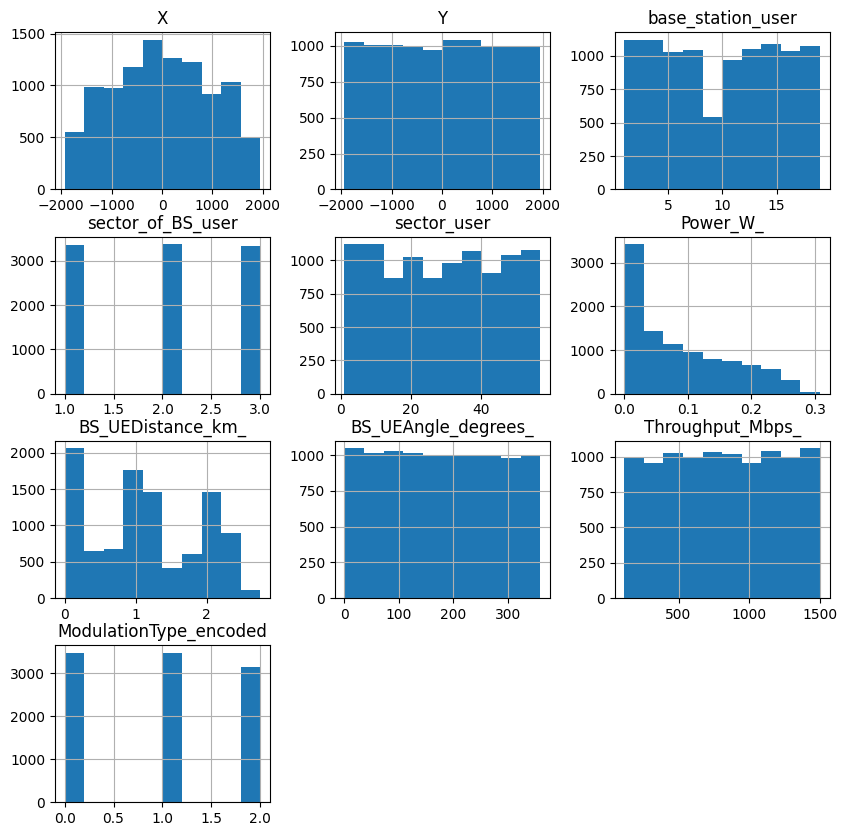

In [6]:
_ = df.hist(figsize=(10, 10))

We will investigate linear dependencies between our independent variables.

We observe that *sector_user* and *base_station_user* have a perfect spearman correlation of 1.

We must address this.

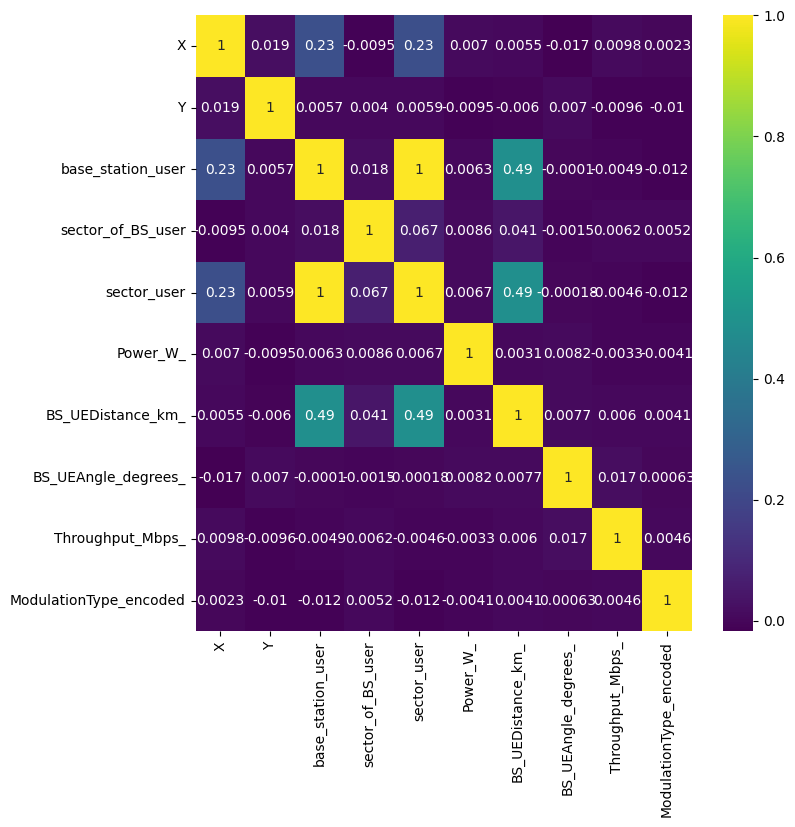

In [7]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
_ = plt.show()

Let us visualize the relationship with a scatterplot.

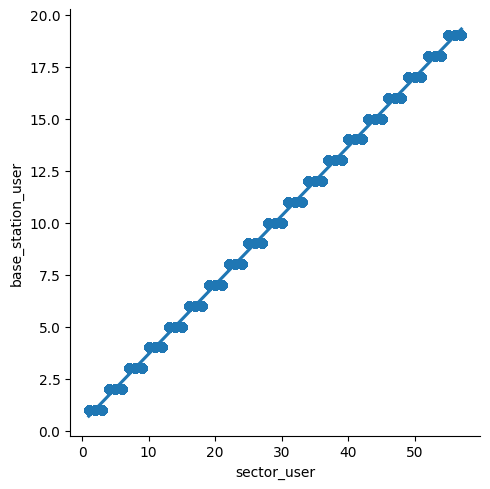

In [8]:
_ = sns.lmplot(x='sector_user', y='base_station_user', data=df)

To decide on which feature to retain and which to discard from the correlated pair *sector_user* and *base_station_user* we will fit a RandomForest model and see what feature importance does it assign to each feature.

We see that *sector_user* is more than twice as important as *base_station_user*, which hints us that we might have to remove *base_station_user*.

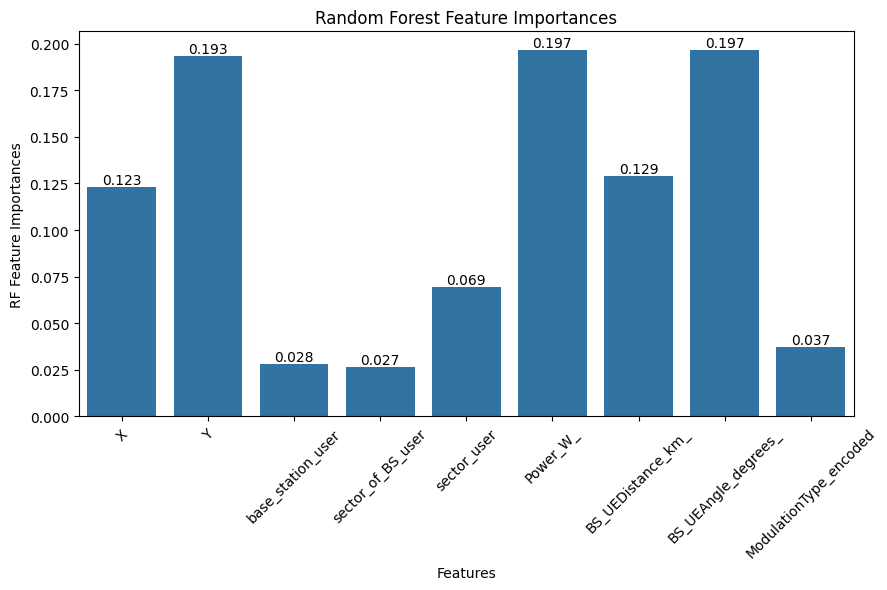

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(df.drop(columns=['Throughput_Mbps_', "ModulationType"]), y=df['Throughput_Mbps_'])

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=df.drop(columns=['Throughput_Mbps_', "ModulationType"]).columns, 
    y=model.feature_importances_
)

for bar, importance in zip(ax.patches, model.feature_importances_):
    ax.annotate(
        f'{importance:.3f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.xlabel("Features")
plt.ylabel("RF Feature Importances")
plt.title("Random Forest Feature Importances")

plt.xticks(rotation=45)
plt.show()



Another feature selection technique for correlated features is using variance as a metric and choose features with high variance.

We again observe that *sector_user* has almost 3 times as much variance as *base_station_user*

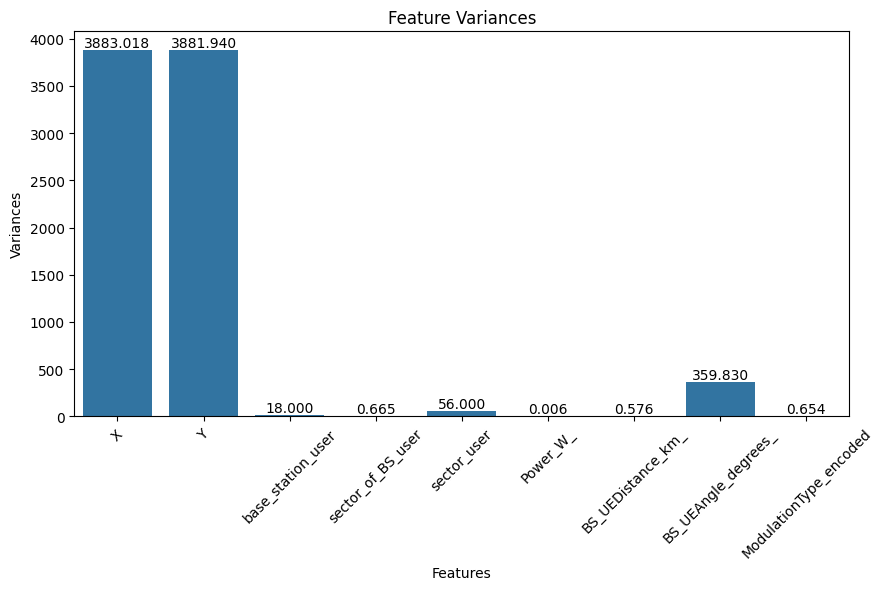

In [10]:
selector = VarianceThreshold()

variance = selector.fit_transform(df.drop(columns=['Throughput_Mbps_', "ModulationType"]))

variances = selector.variances_

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=df.drop(columns=['Throughput_Mbps_', "ModulationType"]).columns, 
    y=selector.variances_
)

for bar, importance in zip(ax.patches, selector.variances_):
    ax.annotate(
        f'{importance:.3f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.xlabel("Features")
plt.ylabel("Variances")
plt.title("Feature Variances")

plt.xticks(rotation=45)
plt.show()


Therefore we decided on retaining *sector_user* and on dropping *base_station_user*.

We see that there are no highly correlated features in our data now.

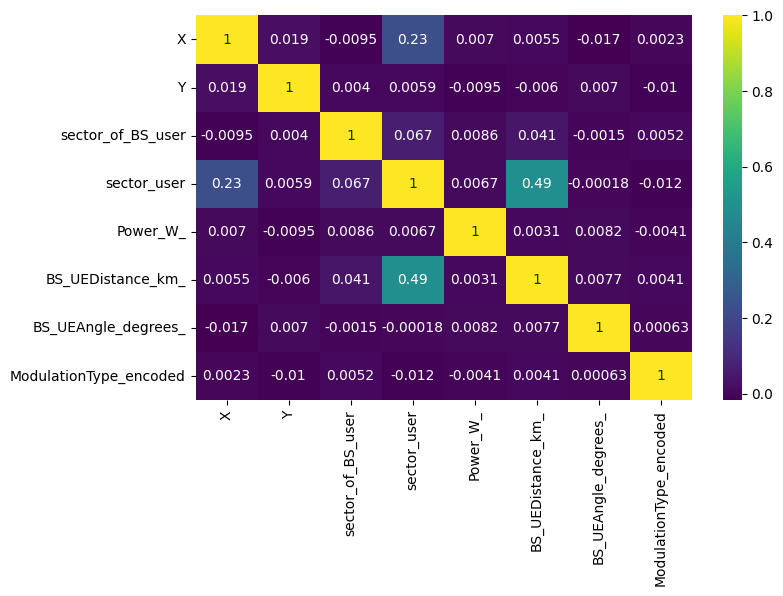

In [11]:
df = df.drop(columns=['ModulationType', 'base_station_user'])
plt.figure(figsize=(8, 5))
_ = sns.heatmap(df.drop(columns=["Throughput_Mbps_"]).corr(), annot=True, cmap="viridis")

Split features from target

In [12]:
X = df.drop(columns='Throughput_Mbps_')
y = df['Throughput_Mbps_']

## Regression

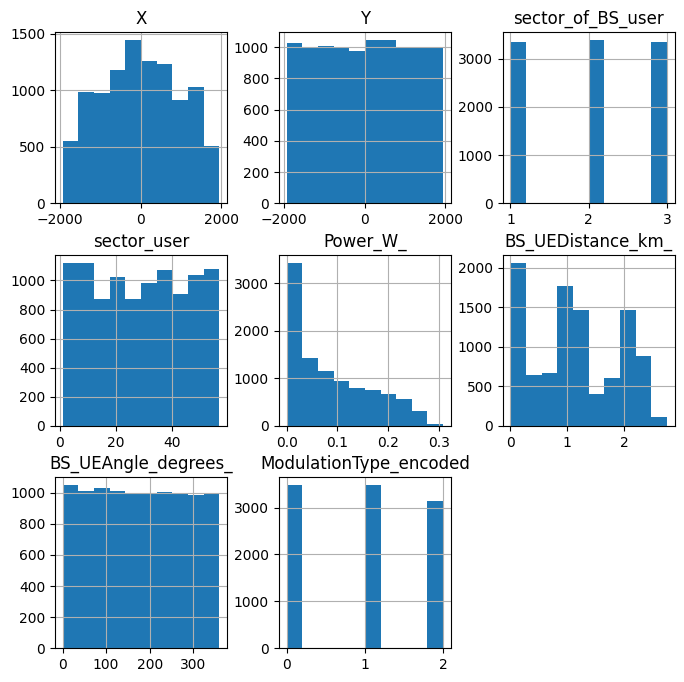

In [13]:
_ = X.hist(figsize=(8, 8))

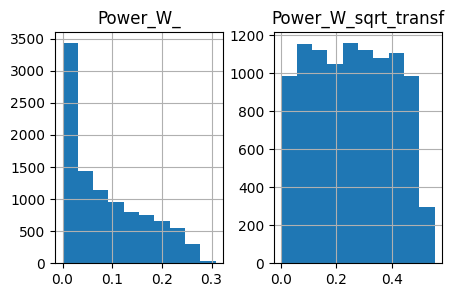

In [14]:
X["Power_W_sqrt_transf"] = np.sqrt(X["Power_W_"])

_ = X[["Power_W_", "Power_W_sqrt_transf"]].hist(figsize=(5, 3))

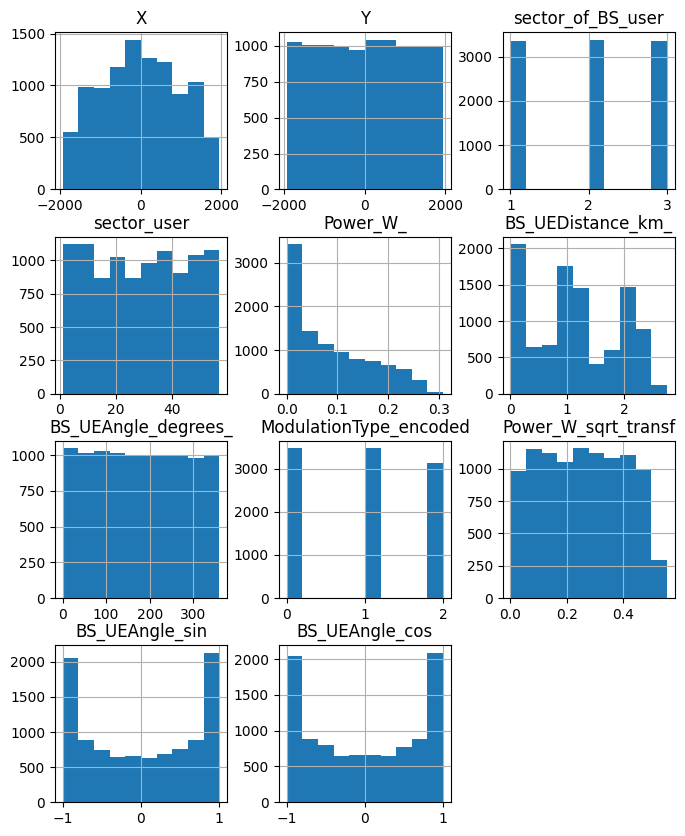

In [15]:
X['BS_UEAngle_sin'] = np.sin(np.radians(X['BS_UEAngle_degrees_']))
X['BS_UEAngle_cos'] = np.cos(np.radians(X['BS_UEAngle_degrees_']))
_ = X.hist(figsize=(8, 10))

<Axes: >

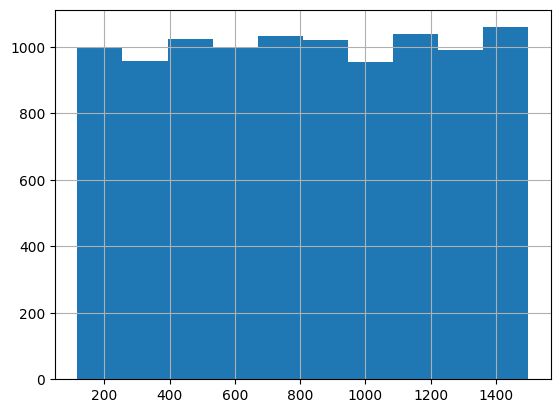

In [22]:
y.hist()

In [16]:
X.columns

Index(['X', 'Y', 'sector_of_BS_user', 'sector_user', 'Power_W_',
       'BS_UEDistance_km_', 'BS_UEAngle_degrees_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos'],
      dtype='object')

In [47]:
X_MLP = X[['X', 'Y', 'sector_of_BS_user', 'sector_user', 'BS_UEDistance_km_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos']]

In [50]:
RANDOM_SEED=42

X_MLP_train, X_MLP_val, y_mlp_train, y_mlp_val = train_test_split(X_MLP, y, random_state=RANDOM_SEED, test_size=0.2)

In [59]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(-1, 1))

X_MLP_train = feature_scaler.fit_transform(X_MLP_train)
y_mlp_train = target_scaler.fit_transform(y_mlp_train.to_numpy().reshape(-1, 1))
X_MLP_val = feature_scaler.transform(X_MLP_val)
y_mlp_val = target_scaler.fit_transform(y_mlp_val.to_numpy().reshape(-1, 1))

In [99]:
regressors_parametered = [
    ("MLPRegressor", MLPRegressor(random_state=RANDOM_SEED, 
                                  max_iter=1000,
                                  early_stopping=True,
                                  activation="tanh",),
    {"classifier__hidden_layer_sizes": [[128, 128, 128, 128, 128], [256, 256, 256, 256, 256], [512, 512, 512, 512, 512]],
     "classifier__solver": ['sgd', 'adam'],
     "classifier__learning_rate": ['invscaling', 'adaptive'],
     "classifier__learning_rate_init": [0.001, 0.01]})
]

In [100]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scorer = make_scorer(mean_squared_error)

In [101]:
best_params, best_models = {}, {}

for name, regressor, param_grid in regressors_parametered:
    pipeline = Pipeline([('classifier', regressor)])
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, n_jobs=4)
    grid_search.fit(X_MLP_train, y_mlp_train.ravel())
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    print(f"Best Parameters for {name}: {best_params[name]}")

Best Parameters for MLPRegressor: {'classifier__hidden_layer_sizes': [512, 512, 512, 512, 512], 'classifier__learning_rate': 'invscaling', 'classifier__learning_rate_init': 0.001, 'classifier__solver': 'sgd'}


In [102]:


# Model 1 predictions and evaluation
y_pred_mlp = best_models['MLPRegressor'].predict(X_MLP_val)
mse_mlp = mean_squared_error(y_mlp_val, y_pred_mlp)
mae_mlp = mean_absolute_error(y_mlp_val, y_pred_mlp)
r2_mlp = r2_score(y_mlp_val, y_pred_mlp)

print("\nMLP Model Performance:")
print(f"MSE: {mse_mlp}, MAE: {mae_mlp}, R^2: {r2_mlp}")



MLP Model Performance:
MSE: 0.08595819555202318, MAE: 0.25295906572538085, R^2: -0.009681284646781085
